In [18]:
import datetime

import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (8,6)
import seaborn as sns
import numpy as np

In [19]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy import stats

In [20]:
INPUT_DIR = "input/"

In [21]:
data = pd.read_csv(INPUT_DIR + "daily_production.csv")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [22]:
data.head()

,gasvol,choke,hrsonline,whp,wht,hrsoffline,year,week,dayofweek
date,,,,,,,,,
2005-01-11,1790574.461,35.8,24.0,163.0,53.5,0.0,2005,2,1
2005-01-12,2610154.532,97.4,24.0,72.3,43.3,0.0,2005,2,2
2005-01-13,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,3
2005-01-14,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,4
2005-01-15,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,5


In [23]:
data.describe()

,gasvol,choke,hrsonline,whp,wht,hrsoffline,year,week,dayofweek
count,5.080000e+03,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000
mean,4.517001e+05,64.505906,18.132953,28.051555,32.831752,5.867047,2011.483465,26.507283,3.000000
std,5.511638e+05,44.109146,9.554588,21.576947,15.090307,9.554588,4.009995,14.978016,1.999705
min,0.000000e+00,0.000000,0.000000,0.000000,-20.000000,0.000000,2005.000000,1.000000,0.000000
25%,4.661764e+04,1.200000,14.075000,17.700000,28.375000,0.000000,2008.000000,14.000000,1.000000
50%,2.415290e+05,96.600000,24.000000,24.400000,37.800000,0.000000,2011.000000,26.500000,3.000000
75%,6.537928e+05,98.800000,24.000000,31.100000,43.800000,9.925000,2015.000000,39.000000,5.000000
max,2.737552e+06,100.000000,24.000000,190.300000,73.900000,24.000000,2018.000000,53.000000,6.000000


In [24]:
# 目的変数と説明変数（特徴量）の選択

target = ['gasrate']
# features = ['choke', 'whp', 'wht', 'year', 'week', 'dayofweek'] 
features = ['choke','hrsonline','whp', 'year', 'week', 'dayofweek'] # whtはどちらかというと結果なのでリークの恐れあり。

data['gasrate'] = (data['gasvol'] / data['hrsonline'])#.apply(np.log1p)

In [25]:
# 追加の説明変数
## LigthGBMなどの決定木系アルゴリズムでは多重共線性をあまり気にせずに特徴量をたくさん入れることができる。
## しかし、Train/Validに過学習してしまうためやり過ぎに注意。
## ヒアリングでアイディアを探す。

# 過去の生産レート
for l in range(1,10):
    data[f'rate_shift_{l}d'] = data['gasrate'].shift(l).bfill()
    features.append(f'rate_shift_{l}d')
    

# # 直近のシャットイン時間
# for l in range(1,10):
#     data[f'hrsoffline_shift_{l}d'] = data['hrsoffline'].shift(l).bfill()
#     features.append(f'hrsoffline_shift_{l}d')

In [26]:
data.head()

,gasvol,choke,hrsonline,whp,wht,hrsoffline,year,week,dayofweek,gasrate,rate_shift_1d,rate_shift_2d,rate_shift_3d,rate_shift_4d,rate_shift_5d,rate_shift_6d,rate_shift_7d,rate_shift_8d,rate_shift_9d
date,,,,,,,,,,,,,,,,,,,
2005-01-11,1790574.461,35.8,24.0,163.0,53.5,0.0,2005,2,1,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208
2005-01-12,2610154.532,97.4,24.0,72.3,43.3,0.0,2005,2,2,108756.438833,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208
2005-01-13,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,3,NaN,108756.438833,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208
2005-01-14,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,4,NaN,74273.947958,108756.438833,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208
2005-01-15,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,5,NaN,74273.947958,74273.947958,108756.438833,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208,74607.269208


In [27]:
data.shape

(5080, 19)

In [28]:
train_start = datetime.datetime(2012, 1, 1)
test_start = datetime.datetime(2017, 9, 1)
test_end = datetime.datetime(2018, 9, 1)

In [29]:
cond = data['hrsonline'] > 20 #元のデータの75％は20時間以上Online
cond &= data['gasrate'] > 0 #Onlineでも生産量０は不正値とみなす。

df = data[cond].copy() # copyしないとメモリ上で値を共有するので片方をいじるともう片方も更新されてしまう。
df_train = df[(df.index >= train_start) & (df.index < test_start)] #Prophetは内部パラメータ最適化が無いのでValidが不要
df_test = df[(df.index >= test_start) & (df.index < test_end)]

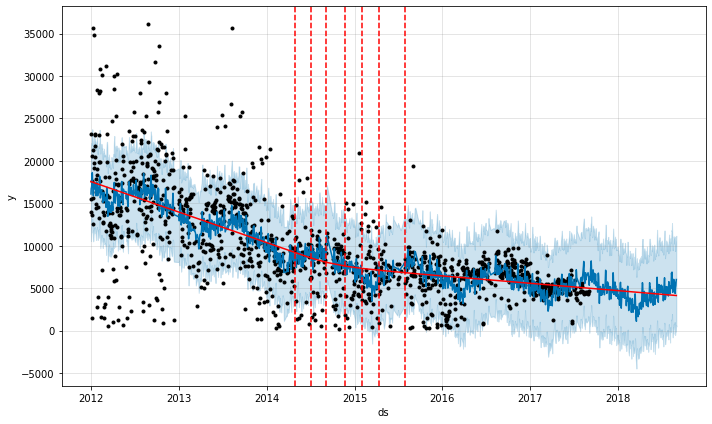

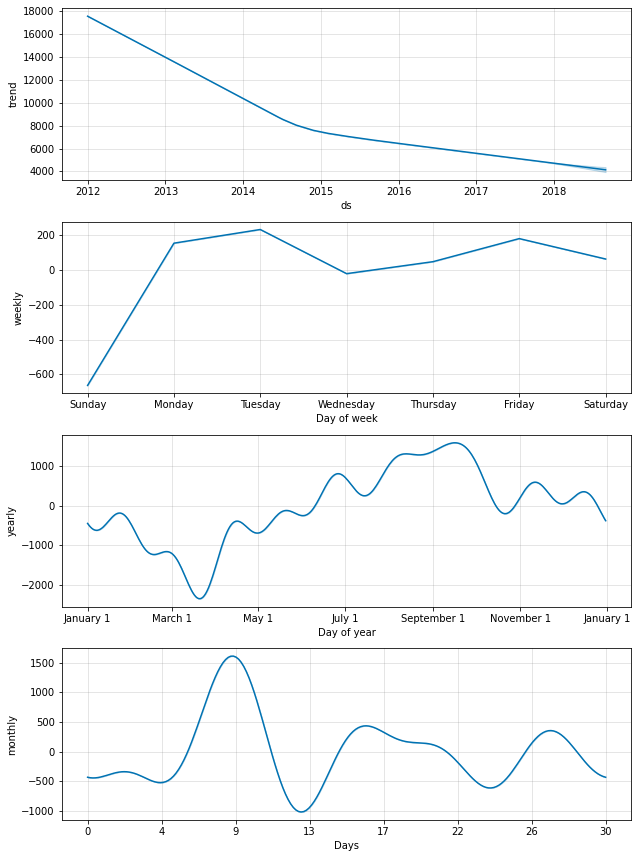

In [44]:
data_train = df_train.reset_index(drop=False).rename(columns={'date':'ds', 'gasrate':'y'})[['ds', 'y']].copy()
data_test = df_test.reset_index(drop=False).rename(columns={'date':'ds', 'gasrate':'y'})[['ds', 'y']].copy()

prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=True,
                  yearly_seasonality=True,
                  seasonality_mode='additive')
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.fit(data_train)
future = prophet.make_future_dataframe(periods=365, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
prophet.plot_components(forecast)
plt.show()

In [45]:
def plot_prediction(forecast, data_test):
    output = pd.merge(data_test, forecast , on='ds', how='left').set_index('ds')

    cond = (output.index >= test_start) & (output.index < test_end)
    actual = output[cond]['y']#.apply(np.expm1)
    pred = output[cond]['yhat']#.apply(np.expm1)

    mape = (np.abs(pred - actual) / actual * 100).mean()
    
    plt.title('Prophet prediction vs actual')
    actual.plot(label='actual')
    pred.plot(label=f'predict, MAPE:{mape:.2f} %')
    plt.ylabel('gas rate (sm3/hr)')
    plt.legend()
    plt.show()
    
    plt.title('Prophet residual') 
    (pred - actual).plot(label='residual')
    plt.legend()
    plt.show()

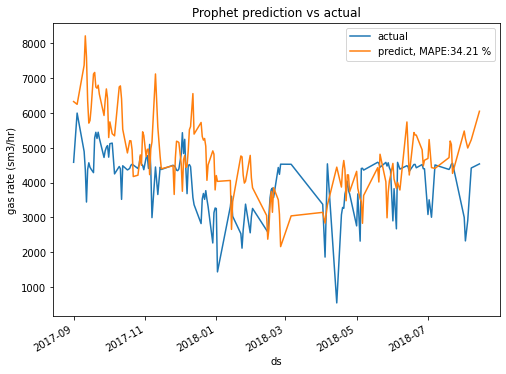

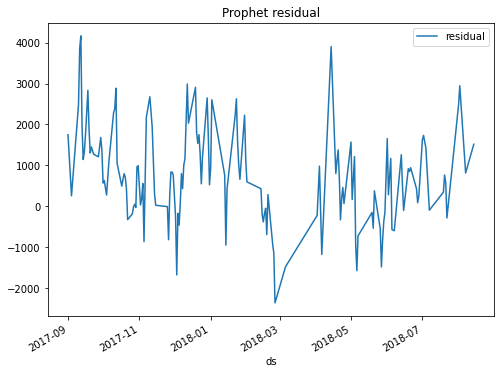

In [46]:
plot_prediction(forecast, data_test)

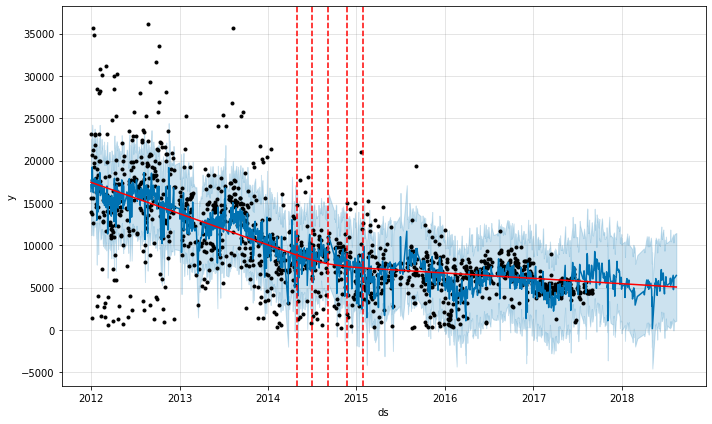

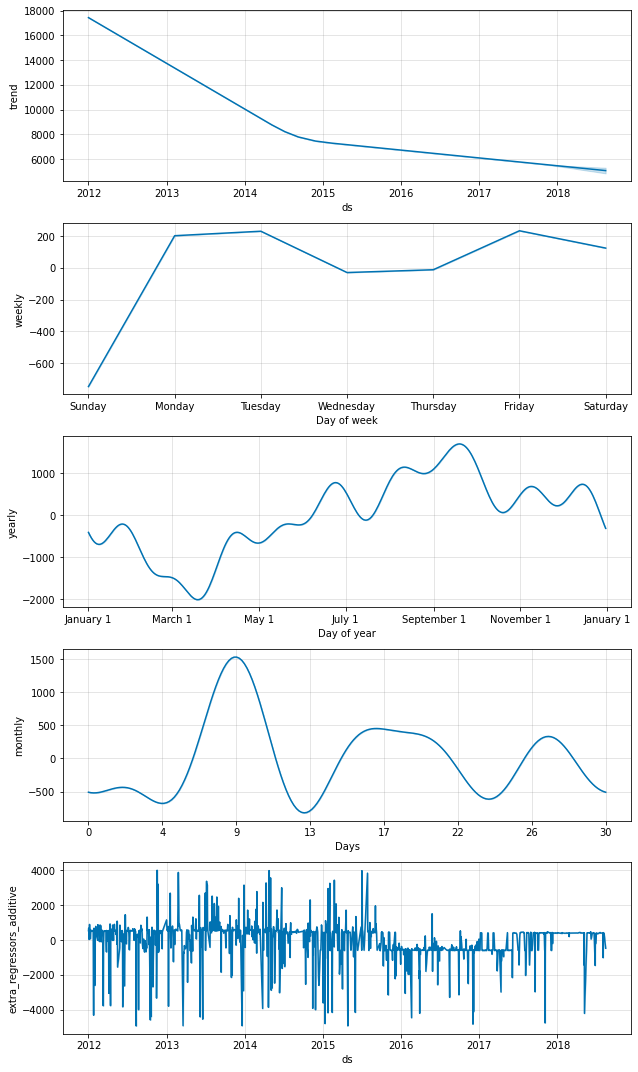

In [47]:
data_train = df_train.reset_index(drop=False).rename(columns={'date':'ds', 'gasrate':'y'})[['ds', 'y','choke', 'whp', 'hrsonline']].copy()
data_test = df_test.reset_index(drop=False).rename(columns={'date':'ds', 'gasrate':'y'})[['ds', 'y','choke', 'whp', 'hrsonline']].copy()


prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=True,
                  yearly_seasonality=True,
                  seasonality_mode='additive')
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.add_regressor('choke')
prophet.add_regressor('whp')
prophet.add_regressor('hrsonline')
prophet.fit(data_train)
future = prophet.make_future_dataframe(periods=365, freq="D")

df_renamed = df.reset_index(drop=False).rename(columns={'date':'ds', 'gasrate':'y'})

future = pd.merge(future, df_renamed[['ds', 'choke', 'whp', 'hrsonline']], on='ds', how='left').dropna() 
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
prophet.plot_components(forecast)
# data_test.set_index('ds').plot()
plt.show()

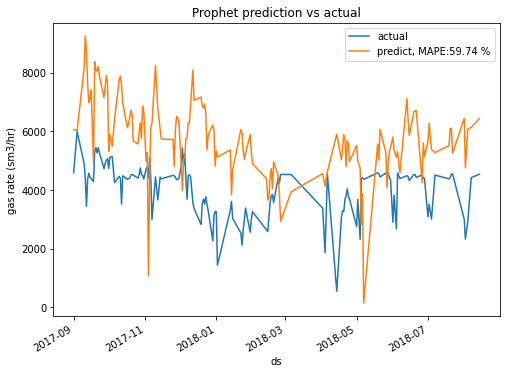

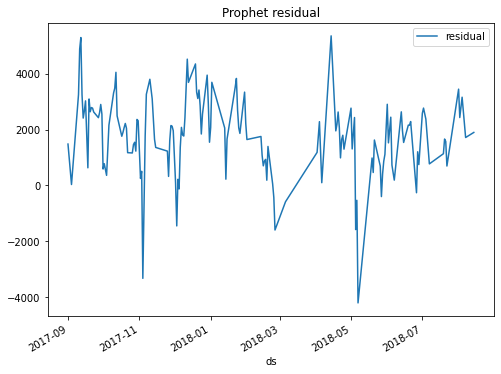

In [48]:
plot_prediction(forecast, data_test)